<a href="https://colab.research.google.com/github/Ritikaverma2021/Distracted_Driver/blob/main/ResNet50_No_Extra_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import tensorflow
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

In [ ]:
!nvidia-smi

Sat Oct  1 02:25:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
driver_details = pd.read_csv('/content/drive/MyDrive/mini_data_set/Copy of driver_imgs_list (1).csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
# getting all the images
train_image = []
image_label = []


for i in range(10):
    print('folder C',i)
    imgs = os.listdir("/content/drive/MyDrive/mini_data_set/Train/C"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/drive/MyDrive/mini_data_set/Train/C"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

folder C 0
folder C 1
folder C 2
folder C 3
folder C 4
folder C 5
folder C 6
folder C 7
folder C 8
folder C 9


In [ ]:
# Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
# getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])
driv_selected 

['p056', 'p021', 'p002', 'p045']

In [ ]:
# training and splitting the training and testing data

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []
true_test =[]

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
        true_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

4227 773
4227 773


In [ ]:
# Converting images to nparray. Encoding the Y.

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(X_train.shape)
print(y_train.shape)

(4227, 224, 224, 3)
(4227, 10)


In [ ]:
# Defining the inputs for Resnet50 model

from keras.layers import Input
resnet50_input = Input(shape=(224,224,3), name ='Image_input')

# The Resent50 model

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

model_resnet50_conv = ResNet50(weights='imagenet', include_top= False, input_shape = (224,224,3))
model_resnet50_conv.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# Use of the generated model 

from keras.models import Model

output_resnet50_conv = model_resnet50_conv(resnet50_input)

# Add the fully connected layers

x = Flatten(name ='flatten')(output_resnet50_conv)
x = Dense(10, activation='softmax', name='prediction')(x)

resnet50_pretrained = Model(resnet50_input,x)
resnet50_pretrained.summary()

# Compile CNN model
adam = tensorflow.keras.optimizers.Adam( lr = 0.001, beta_1=0.9, beta_2 =0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr=0.001)
resnet50_pretrained.compile(loss = 'categorical_crossentropy', optimizer=sgd,metrics = ['accuracy'])
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
        math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 prediction (Dense)          (None, 10)                1003530   
                                                                 
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper,lrate],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
67/66 [==============================] - ETA: 0s - loss: 3.6991 - accuracy: 0.1675
Epoch 1: val_loss improved from inf to 2.77603, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
66/66 [==============================] - 81s 928ms/step - loss: 3.6991 - accuracy: 0.1675 - val_loss: 2.7760 - val_accuracy: 0.3441 - lr: 0.0010
Epoch 2/25
67/66 [==============================] - ETA: 0s - loss: 2.9631 - accuracy: 0.2815
Epoch 2: val_loss improved from 2.77603 to 1.74180, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
66/66 [==============================] - 59s 882ms/step - loss: 2.9631 - accuracy: 0.2815 - val_loss: 1.7418 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 3/25
67/66 [==============================] - ETA: 0s - loss: 2.4149 - accuracy: 0.3700
Epoch 3: val_loss did not improve from 1.74180
66/66 [==============================] - 59s 882ms/step - loss: 2.4149 - accuracy: 0.3700 - val_loss: 2.8624 - val_accuracy: 0.4942 - lr: 0.0010
Epoch 4/25

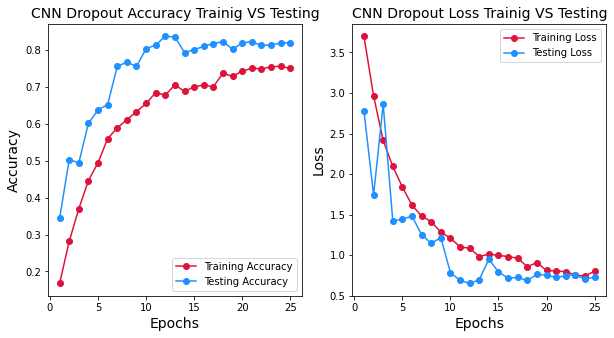

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')


axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

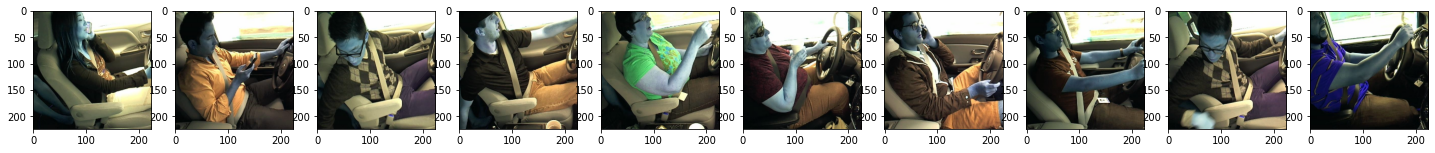

In [ ]:
# Labels is the image array
test_images =[]
i=0
fig,ax =plt.subplots(1,10, figsize=(25,25))

files = os.listdir('/content/drive/MyDrive/mini_data_set/Test')
nums = np.random.randint(low=1, high =len(files), size =10)
for i in range(10):
  #print('Image Number : ', i)
  img = cv2.imread('/content/drive/MyDrive/mini_data_set/Test/'+ files[nums[i]])
  img = img [50:, 120:-50]
  img = cv2.resize(img,(224,224))
  test_images.append(img)
  ax[i].imshow(img, cmap='gray')
  plt.show

In [ ]:
test =[]
 
for img in test_images:
  test.append(img)

resnet50_pretrained.load_weights('resnet_weights_aug_alltrained_sgd2_setval.hdf5')

test = np.array(test).reshape(-1,224,224,3)
prediction =  resnet50_pretrained.predict(test)

In [ ]:
prediction[7]

array([9.7240281e-01, 9.4255137e-09, 4.0038951e-11, 3.2722506e-05,
       6.5077838e-05, 4.3386305e-04, 3.2324207e-10, 8.1434308e-07,
       5.9973985e-08, 2.7064694e-02], dtype=float32)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

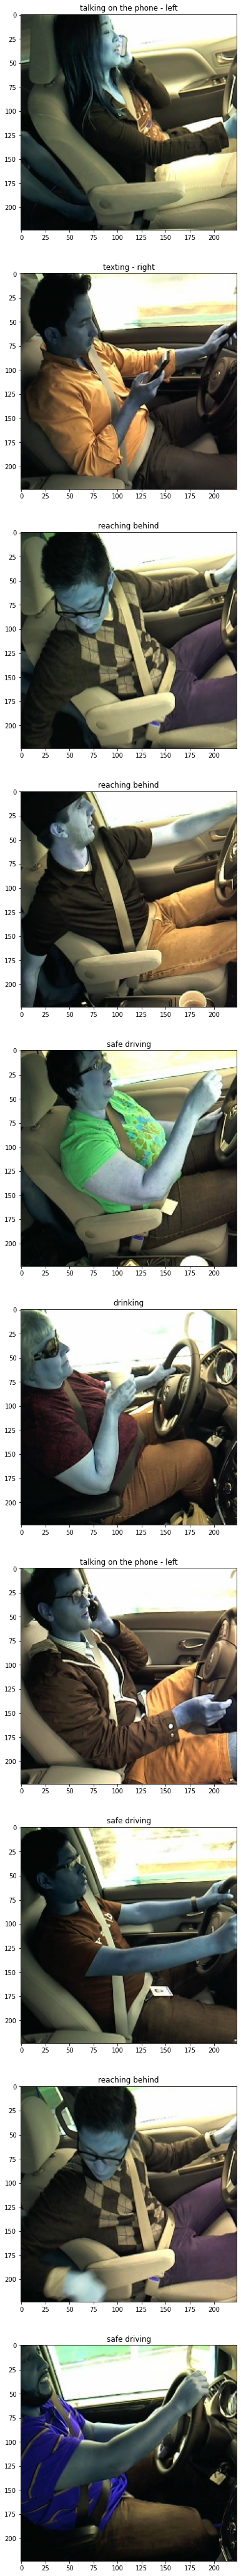

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (75,75))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

In [ ]:
model3_prediction = []
model3_pred_class = []

model3_prediction = resnet50_pretrained.predict(X_test)
print('Images Predicted until now:',len(model3_prediction))


for i in range(len(model3_prediction)):
    model3_pred_class.append(np.where(model3_prediction[i] == np.amax(model3_prediction[i]))[0][0])

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix  

print('The accuracy of this model over validation set is:',accuracy_score(true_test,model3_pred_class))


model3_pred_class_n =[]
for result in model3_pred_class:
  result = result.astype(str)
  model3_pred_class_n.append(result)

confusion_matrix(true_test,model3_pred_class_n)

Images Predicted until now: 773
The accuracy of this model over validation set is: 0.0


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [19, 15,  5, 22, 17, 14, 15, 15, 25, 11,  0,  0,  0,  0],
       [35, 36, 24, 24, 43, 22, 22, 22, 20, 28,  0,  0,  0,  0],
       [ 3, 20, 19, 18, 15, 10, 20, 12, 18, 24,  0,  0,  0,  0],
       [23, 25, 15, 18, 12, 20, 16, 34, 10,  7,  0,  0,  0,  0]])

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model3_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.65
